In [1]:
import torch
import monai
from glob import glob
from monai.transforms import Compose
from pathlib import Path
import torchio as tio
import os
from tqdm import tqdm
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import monai.networks
import monai.networks.nets

/home/johannes/anaconda3/envs/medicaldino/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# TCGA - All
volumes_list = []
segmentations_list = []
volumes_list.extend(glob("/home/johannes/Code/3DMedicalDINO/data/tcga/*/preop/*space-sri_t1c.nii.gz"))
# volumes_list.extend(glob("/home/johannes/Code/3DMedicalDINO/data/tcga/*/preop/*space-sri_flair.nii.gz"))
segmentations_list.extend(glob("/home/johannes/Code/3DMedicalDINO/data/tcga/*/preop/*space-sri_seg.nii.gz"))
# segmentations_list.extend(glob("/home/johannes/Code/3DMedicalDINO/data/tcga/*/preop/*space-sri_seg.nii.gz"))   

volumes_list = sorted(volumes_list)
segmentations_list = sorted(segmentations_list)

In [3]:
def get_crop(img, seg):             
            
    volume = img

    filename = volume.split("/")[-1]
    parent_path = Path(volume).parent

    if ("T1" in filename) or ("t1" in filename):
        t1_file = volume
        if "UCSF" in str(parent_path):
            flair_file = glob(os.path.join(parent_path, "*FLAIR_skull_normalized.nii.gz"))[0]
        elif "erasmus" in str(parent_path):
            flair_file = glob(os.path.join(parent_path, "*preop_space-sri_flair.nii.gz"))[0]
        elif "tcga" in str(parent_path):
            flair_file = glob(os.path.join(parent_path, "*preop_space-sri_flair.nii.gz"))[0]

    else:
        flair_file = volume
        if "UCSF" in str(parent_path):
            t1_file = glob(os.path.join(parent_path, "*T1c_skull_normalized.nii.gz"))[0]
        elif "erasmus" in str(parent_path):
            t1_file = glob(os.path.join(parent_path, "*preop_space-sri_t1c.nii.gz"))[0]
        elif "tcga" in str(parent_path):
            t1_file = glob(os.path.join(parent_path, "*preop_space-sri_t1c.nii.gz"))[0]
        

    segmentation = seg

    t1_tio = tio.ScalarImage(t1_file)
    flair_tio = tio.ScalarImage(flair_file)
    seg_tio = tio.LabelMap(segmentation)

    t1_tio_aligned = tio.ToCanonical()(t1_tio)
    flair_tio_aligned = tio.ToCanonical()(flair_tio)
    seg_tio_aligned = tio.ToCanonical()(seg_tio)

    seg_tio_resampled = tio.Resample(target=t1_tio_aligned)(seg_tio_aligned)
    
    t1_subject = tio.Subject(img = t1_tio_aligned, seg = seg_tio_resampled)
    flair_subject = tio.Subject(img = flair_tio_aligned, seg = seg_tio_resampled)
    
    t1_subject_crop = tio.CropOrPad(mask_name="seg")(t1_subject)
    flair_subject_crop = tio.CropOrPad(mask_name="seg")(flair_subject)

    t1_img_crop = t1_subject_crop.img.tensor
    flair_img_crop = flair_subject_crop.img.tensor

    img_crop = torch.unsqueeze(torch.concatenate([t1_img_crop, flair_img_crop], dim=0), dim=0)

    return img_crop

  0%|          | 0/243 [00:00<?, ?it/s]

100%|██████████| 243/243 [01:11<00:00,  3.42it/s]


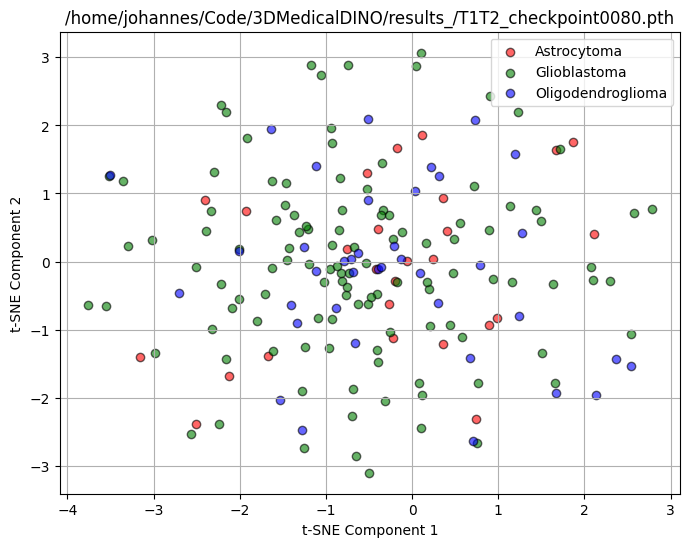

In [4]:
dims = []

for checkpoint_path in glob("/home/johannes/Code/3DMedicalDINO/results_/T1T2_check*.pth")[:1]:
    model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=2, out_channels=1).features
    model.load_state_dict(torch.load(checkpoint_path, weights_only=False)["teacher"], strict=False)

    features = []
    labels = []
    df = pd.read_csv("/home/johannes/Code/3DMedicalDINO/data/tcga/histology.csv")

    for i in tqdm(range(len(volumes_list))):
        
        try:
            img = volumes_list[i]
            seg = segmentations_list[i]
            patient_id = img.split("/")[-3]
            label = df[df["case_submitter_id"] == patient_id]["primary_diagnosis"].item()

            if label not in ['Astrocytoma, NOS', 'Astrocytoma, anaplastic', 'Glioblastoma', 'Oligodendroglioma, NOS', 'Oligodendroglioma, anaplastic']:
                continue

            img_crop = get_crop(img, seg)   

            out = model(img_crop)

            dims.append(img_crop.shape)
            labels.append(label)
            features.append(out.mean(dim=[2,3,4]))
        
        except:
            continue

    features = torch.concatenate(features)
    labels = ["Astrocytoma" if "Astrocytoma" in label else "Glioblastoma" if "Glioblastoma" in label else "Oligodendroglioma" for label in labels]
    labels = np.array(labels)

    data_np = features.detach().numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    data_2d = tsne.fit_transform(data_np)

    plot_data = pd.DataFrame({
        'x': data_2d[:, 0],
        'y': data_2d[:, 1],
        'label': labels
    })

    # Step 6: Plot the 2D visualization with colored points based on labels
    plt.figure(figsize=(8, 6))
    colors = {'Astrocytoma': 'red', 'Glioblastoma': 'green', 'Oligodendroglioma': 'blue'}
    for label in colors:
        subset = plot_data[plot_data['label'] == label]
        plt.scatter(subset['x'], subset['y'], c=colors[label], label=label, alpha=0.6, edgecolors='k')

    plt.title(f"{checkpoint_path}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

    

In [5]:
dims

[torch.Size([1, 2, 47, 112, 73]),
 torch.Size([1, 2, 44, 68, 45]),
 torch.Size([1, 2, 58, 88, 86]),
 torch.Size([1, 2, 52, 65, 52]),
 torch.Size([1, 2, 73, 95, 81]),
 torch.Size([1, 2, 72, 88, 74]),
 torch.Size([1, 2, 71, 97, 72]),
 torch.Size([1, 2, 96, 114, 95]),
 torch.Size([1, 2, 73, 112, 92]),
 torch.Size([1, 2, 77, 109, 86]),
 torch.Size([1, 2, 66, 79, 60]),
 torch.Size([1, 2, 63, 105, 78]),
 torch.Size([1, 2, 53, 61, 45]),
 torch.Size([1, 2, 52, 88, 60]),
 torch.Size([1, 2, 73, 84, 82]),
 torch.Size([1, 2, 35, 69, 77]),
 torch.Size([1, 2, 60, 94, 75]),
 torch.Size([1, 2, 52, 79, 68]),
 torch.Size([1, 2, 97, 96, 76]),
 torch.Size([1, 2, 57, 75, 69]),
 torch.Size([1, 2, 69, 64, 90]),
 torch.Size([1, 2, 48, 67, 55]),
 torch.Size([1, 2, 78, 128, 89]),
 torch.Size([1, 2, 50, 72, 85]),
 torch.Size([1, 2, 59, 82, 51]),
 torch.Size([1, 2, 73, 94, 72]),
 torch.Size([1, 2, 112, 135, 83]),
 torch.Size([1, 2, 79, 107, 72]),
 torch.Size([1, 2, 70, 97, 78]),
 torch.Size([1, 2, 66, 118, 89]),
